# Mini Projet ML

Rendu final du mini projet ML propopsé par l'IA School.

Les étapes imposées dans le cadre de ce projet étaient les suivantes :

1) Récupération de données sur l'internet via scraping
2) Nettoyage et traitement des données
3) Entraînement d'un modèle de regression, de classification ou de clustering
4) Présentation des performances du modèle choisi

Pour ce projet, j'ai choisi l'étude du site de [Marmiton](https://www.marmiton.org).

L'un des premiers problèmes rencontrés était l'utilisation de méthodes anti-scraping 
par Marmiton pour les addresses IP détectées comme nuisibles (en générant dynamiquement
les éléments structurels de la pages et leurs identifiants)

En récupérant les données des recettes, et nottament les plats principaux, je souhaite 
proposer une analyse des similitudes parmis les aliments courants et leur apparitions dans 
la composition des recettes.

Par clustering, je souhaite pousser l'analyse pour distinguer des groupes d'ingrédients
semblables et potentiellement interchangeables dans les recettes.

Pour aller plus loin, l'utilisation d'un modèle neuronal de type Tok2Vec permettra 
une analyse plus fine des ingrédients apparaissant dans les mêmes contextes ou 
dans des préparations similaires et donc interchangeables.


<br>

## Librairies

In [1]:
# librairie standard
import json
from pprint import pprint
from itertools import chain

# librairies utiles (à installer)
from tqdm import tqdm

# librairies scraping (à installer)
from requests import get
from bs4 import BeautifulSoup

# librairies graphiques (à installer)
import matplotlib.pyplot as plt

# librairies ML (à installer)
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.metrics import silhouette_score
from gensim.models import Word2Vec


# configuration matplotlib
plt.style.use("Solarize_Light2")
plt.rcParams.update({"font.size": 14, "axes.titlesize": 18})
COLORS = ["#FF9472", "#E93B81", "#3B27BA", "#13CA91"]

/home/splash/Projects/ML_marmiton/venv/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


<br>

## Récupération des données

### Liste des recettes 

In [2]:
# récupération des urls des pages de recette depuis la liste des recettes
# il y a 30 cartes de recette par page et la catégorie plat principaux compte 531 pages

recipe_urls = []

# un trop grand nombre de pages entrainera un temps d'attente plus long pour récupérer 
# toutes les recettes. Une vingtaine de pages suffisent pour produire des résultats
# et ne prendront qu'une à deux minutes à scraper
nb_pages = 20

for page in tqdm(range(nb_pages)):
    # récupérer la page en question 
    page_url = f"https://www.marmiton.org/recettes/index/categorie/plat-principal/{page}"
    response = get(page_url)
    
    # soulever une erreur si le statut de la réponse correspond à une erreur (codes autres que 2xx)
    response.raise_for_status()
    
    # parser la page des recettes pour obtenir les liens vers les pages individuelles
    soup = BeautifulSoup(response.content, "html.parser")
    recipe_urls.extend([recipe["href"] for recipe in soup.select(".recipe-card-link")])

100%|██████████| 20/20 [02:14<00:00,  6.73s/it]


### Détails des recettes

In [3]:
# récupération par page recette des informations utiles au projet

recipes = []

for url in tqdm(recipe_urls):
    
    # comme précedemment, on récupère les informations de la page
    response = get(url)
    
    # cette fois ci, on préfère ne pas soulever d'erreur mais juste avertir
    # et continuer si la page n'a pas pu être atteinte
    if not response.ok:
        print(f"La page {url} n'a pas pu être récupérée ...")
        continue
        
    # sinon on fabrique la soupe
    soup = BeautifulSoup(response.content, "html.parser")
    
    # on initialise un dictionnaire pour la recette
    recipe = {
        "name": "",
        "ingredients": [],
    }
    
    # récuperons d'abord l'intitulé de la recette
    
    # on essaie d'accéder à la balise titre de façon conventionnelle
    title_main = soup.select("h1.main-title")
    # et on essaie la méthode anti-scraping
    title_alt = soup.select('[class^="Titlestyle__TitleContainer"] > h1')
    
    if not (title_main or title_alt):
        # si aucun des deux n'a été trouvé, on affiche le problème et on passe à la recette suivante
        print(f"Aucun nom de recette n'a été trouvé sur la page {url}")
        continue
    else:
        # sinon on récupère la valeur textuelle dans la première balise de title_main ou title_alt selon celle non vide
        title = (title_main or title_alt)[0].text.strip()
        # et on met à jour les informations sur le nom de la recette
        recipe["name"] = title
    
    # maintenant, on passe aux ingrédients
    
    # de façon classique sur la page, on identifie les ingrédients par la classe ingredient-name
    ingredients_main = soup.select(".ingredient-name")
    # mais si les mesures anti-scraping sont en place, les identifiants sont générés dynamiquement
    ingredients_alt = soup.select(".MuiGrid-item > div > span, .MuiGrid-item > div > a > span")
    
    if not (ingredients_main or ingredients_alt):
        # si aucun ingrédient n'a été trouvé, on affiche le problème et on passe à la recette suivante
        print(f"Aucun ingrédient n'a été trouvé sur la page {url}")
        continue
    else:
        # sinon on concatène les listes des balises récupérées (il peut y en avoir dans les deux)
        ingredient_tags = ingredients_main + ingredients_alt
        # et on met à jour les ingrédients de la recette (en supprimant les doublons)
        recipe["ingredients"] = list({el.text.lower().strip() for el in ingredient_tags})
        
    # enfin, on ajoute la recette à la liste
    recipes.append(recipe)
    

 58%|█████▊    | 351/600 [01:06<00:39,  6.36it/s]

Aucun ingrédient n'a été trouvé sur la page https://www.marmiton.org/recettes/recette_boeuf-quel-morceau-choisir_86729.aspx


100%|██████████| 600/600 [01:50<00:00,  5.44it/s]


In [4]:
# quelques exemples
pprint(recipes[:5], sort_dicts=False, compact=True, width=120)

[{'name': 'La vraie Tartiflette',
  'ingredients': ['lardons fumés', 'huile', 'oignon', 'poivre', 'ail', 'reblochon', 'sel', 'pomme de terre']},
 {'name': 'Blanquette de veau facile',
  'ingredients': ['champignon', 'bouillon de poule', 'poivre', 'farine', 'citron', 'carotte', 'oignon jaune',
                  'vin blanc', "jaune d'oeuf", 'blanquette de veau', 'crème fraîche', 'sel', 'cube de bouillon']},
 {'name': 'Lasagnes à la bolognaise',
  'ingredients': ['purée de tomate', 'eau', 'parmesan', 'beurre doux', 'basilic', 'poivre', 'ail', 'lait', 'vin rouge',
                  'lasagnes', 'sel', 'fromage râpé', 'farine', 'oignon jaune', 'muscade', 'thym', 'céleri',
                  'feuille de laurier', 'carotte', 'boeuf haché']},
 {'name': 'Boeuf bourguignon',
  'ingredients': ['beurre', 'oignon', 'poivre', 'carotte', 'vin rouge', 'bourguignon', 'sel', 'bouquet garni']},
 {'name': 'Couscous',
  'ingredients': ['huile', 'beurre', 'navet', 'poivre', 'oignon', 'ail', 'pois chiches', 'c

<br>

## Mise en forme des données

In [5]:
class Booklet:
    """
    Une classe 'Booklet' (pour carnet de recettes) vouée à stocker les différentes 
    recettes du jeu de données et la liste des ingrédients uniques de celles-ci.
    
    Elle implémente un attribut `recipe_vectors` qui permet de transformer la liste
    des recettes en numpy array pour faciliter l'utilisation statistique et l'ingestion
    par les modèles de machine learning.
    
    La méthode `most_similar()` permet d'interroger le booklet sur les recettes les plus
    proches d'une liste d'ingrédients donnée. Elle prend en paramètres une liste d'ingrédients 
    et un nombre de résultats à retourner.
    """
    
    def __init__(self, recipes: list):
        self.recipes = recipes
        self.ingredients = set(chain(*[recipe["ingredients"] for recipe in recipes]))
        
    def __iter__(self):
        return (recipe for recipe in self.recipes)
    
    def __len__(self):
        return len(self.recipes)
    
    @property
    def recipes_names(self) -> list[str]:
        """Liste des noms de recettes"""
        return [recipe["name"] for recipe in self.recipes]
    
    @property
    def recipe_vectors(self) -> np.ndarray:
        """
        Transforme la liste de recette en matrice de taille `nombre_de_recettes` * `nombre_d_ingredients_uniques`
        contenant, sur chaque ligne, la présence ou non d'un ingrédients dans la recette. 
        """
        # boucle sur la liste des recettes puis boucle, pour chaque recette, sur la liste
        # des ingrédients uniques triée pour vérifier sa présence ou non dans la recette
        return np.array([
            [int(ing in recipe["ingredients"]) for ing in sorted(self.ingredients)] 
            for recipe in self.recipes
        ],
        dtype=np.int8)
    
    def most_similar(self, ingredient_list: list[str], n_top: int = 3) -> str:
        """Renvoie les n_top recettes les plus proches de la liste d'ingrédients fournie"""
        input_vec = np.array([int(ing in ingredient_list) for ing in sorted(self.ingredients)])
        recipe_vectors = self.recipe_vectors
        scalar_products = recipe_vectors @ input_vec.T / np.linalg.norm(recipe_vectors, axis=1) / np.linalg.norm(input_vec)
        args_similars = np.argsort(scalar_products)[:-n_top - 1:-1]
        return np.array(self.recipes_names)[args_similars]
        
    def save(self, filename: str = "recipes.json"):
        with open(filename, "w") as f: 
            json.dump(self.recipes, f)
            
    @classmethod
    def load_recipes(cls, recipes: str = "recipes.json"):
        with open(recipes) as f:
            recipes = json.load(f)    
        return cls(recipes)
        

In [6]:
# crée le carnet et le sauvegarde
booklet = Booklet(recipes)
booklet.save("recipes.json")

In [7]:
# ou bien on peut décider de charger un carnet depuis une liste de recettes
# déjà sauvegardée
booklet = Booklet.load_recipes("recipes.json")

In [8]:
# nombre_de_recettes * nombre_d_ingredients_uniques
booklet.recipe_vectors.shape

(599, 605)

In [9]:
# on regarde les recettes les plus proches d'une liste d'ingrédients
# (ici tartiflette normalement)
booklet.most_similar(['pomme de terre', 'reblochon', 'lardons fumés'])

array(['Le wrap tartiflette', "Tartiflette (d'une vraie savoyarde)",
       'La vraie Tartiflette'], dtype='<U69')

<br>

## Exploration des données

### Nombre d'ingrédients par recette

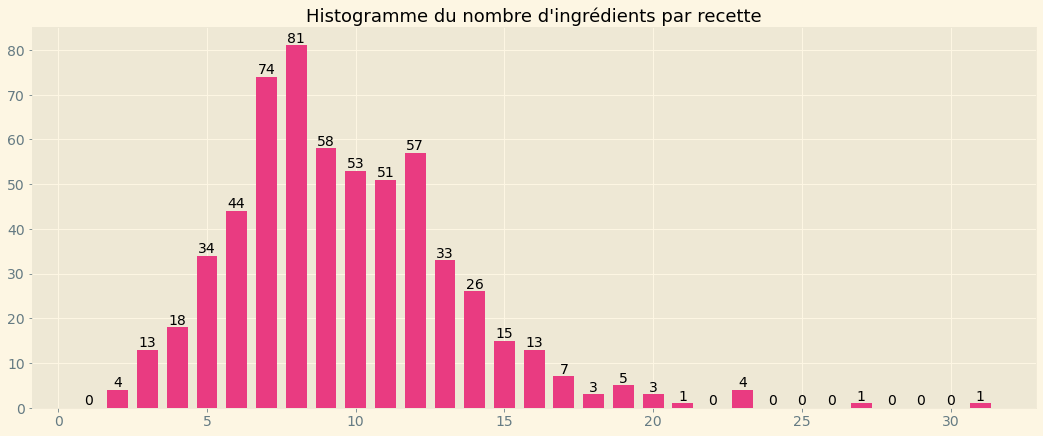

In [10]:
# nombre d'ingrédients par recette
ingredient_count = booklet.recipe_vectors.sum(axis=1)

fig, ax = plt.subplots(figsize=(18, 7))
bar = ax.bar(
    np.arange(1, ingredient_count.max() + 1), 
    np.bincount(ingredient_count)[1:], 
    0.7, 
    color=COLORS[1]
)
ax.bar_label(bar, label_type="edge")
ax.set_title("Histogramme du nombre d'ingrédients par recette")
plt.show()

<br>

### Fréquence d'occurrence des ingrédients

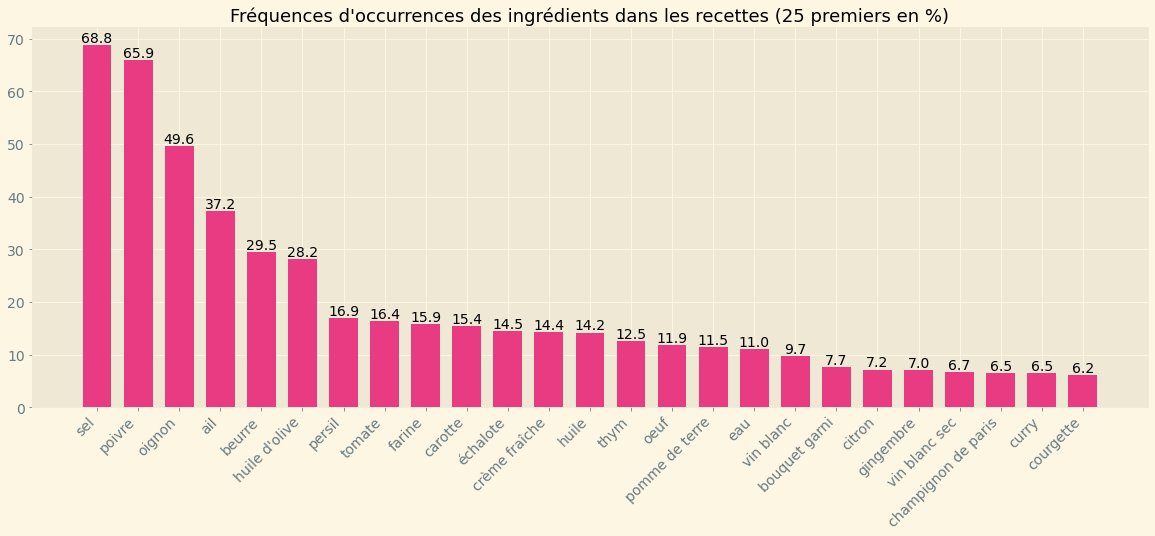

In [11]:
# fréquences d'occurrence des ingrédients dans les recettes
ingredient_frequencies = 100 * booklet.recipe_vectors.sum(axis=0) / len(booklet)
# tri des indices
idx_sort = np.argsort(ingredient_frequencies)[::-1]
# tri des étiquettes (ingrédients)
lbl_sort = np.array(sorted(booklet.ingredients))[idx_sort]

# nombre d'éléments à afficher
nb_ticks = 25

fig, ax = plt.subplots(figsize=(20, 7))
bar = ax.bar(
    lbl_sort[:nb_ticks], 
    ingredient_frequencies[idx_sort][:nb_ticks], 
    0.7, 
    color=COLORS[1]
)
ax.bar_label(bar, label_type="edge", fmt="%1.1f")
ax.set_xticks(lbl_sort[:nb_ticks])
ax.set_xticklabels(lbl_sort[:nb_ticks], rotation=45, ha="right")
ax.set_title(f"Fréquences d'occurrences des ingrédients dans les recettes ({nb_ticks} premiers en %)")
plt.show()

<br>

## Clustering des ingrédients

In [12]:
# on élimine les mots les moins fréquents qui peuvent plomber les résultats des clustering
thresh = 5

# mapping des colonnes de la matrice des ingrédients dont la somme est supérieure au seuil
mask = booklet.recipe_vectors.sum(axis=0) > thresh

# liste des ingrédients correspondants
trimmed_ingredients = np.array(sorted(booklet.ingredients))[mask]

# on récupère la matrice elaguée
trimmed_vectors = booklet.recipe_vectors[:, mask]

In [13]:
# nombre d'ingrédients sélectionnés
len(trimmed_ingredients)

163

<br>

### Par KMeans

In [14]:
# historique des silhouette_scores pour les différents essais
silhouette_scores = []

# essais de KMeans pour plusieurs valeurs de n_clusters
for n_clusters in range(2, 30):
    km = KMeans(n_clusters=n_clusters)
    km.fit(trimmed_vectors.T)
    score = silhouette_score(trimmed_vectors.T, km.labels_)
    silhouette_scores.append(score)

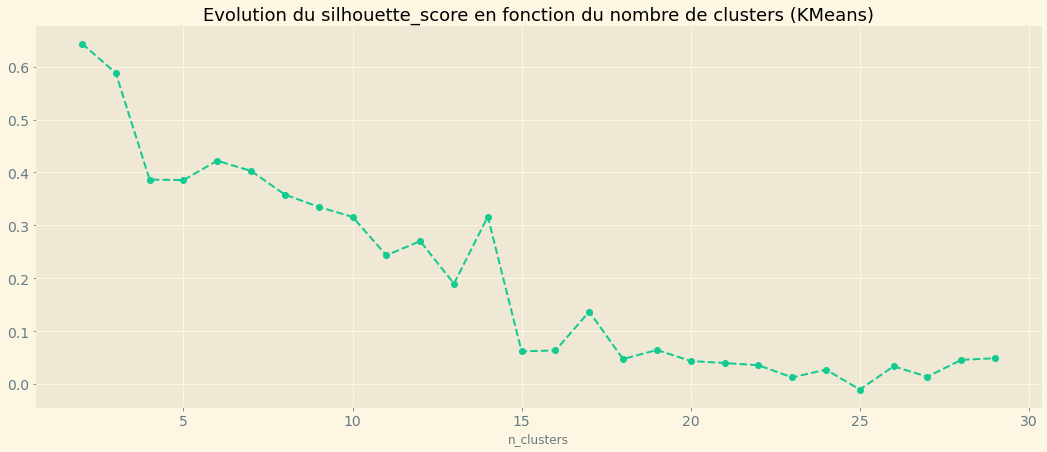

In [15]:
fig, ax = plt.subplots(figsize=(18, 7))
ax.plot(range(2, 30), silhouette_scores, "--o", color=COLORS[3])
ax.set_xlabel("n_clusters")
ax.set_title("Evolution du silhouette_score en fonction du nombre de clusters (KMeans)")
plt.show()

In [16]:
# On entraine un modèle pour la valeur de n_clusters optimale
km = KMeans(n_clusters=12)
km.fit(trimmed_vectors.T)

KMeans(n_clusters=12)

In [17]:
# on peut regarder quelques clusters (de 0 à 11) en changeant la valeur de test sur sc.labels_
trimmed_ingredients[km.labels_ == 2]

array(['beurre'], dtype='<U34')

<br>

### Par AgglomerativeClustering

In [18]:
# historique des silhouette_scores pour les différents essais
silhouette_scores = []

# on pré-calcule la matrice des distances cosinus
cosine_matrix = cosine_distances(trimmed_vectors.T)

# essais de AgglomerativeClustering pour plusieurs valeurs de n_clusters
for n_clusters in range(21, 91, 2):
    ac = AgglomerativeClustering(n_clusters=n_clusters, affinity="precomputed", linkage="complete")
    ac.fit(cosine_matrix)
    score = silhouette_score(trimmed_vectors.T, ac.labels_, metric="cosine")
    silhouette_scores.append(score)

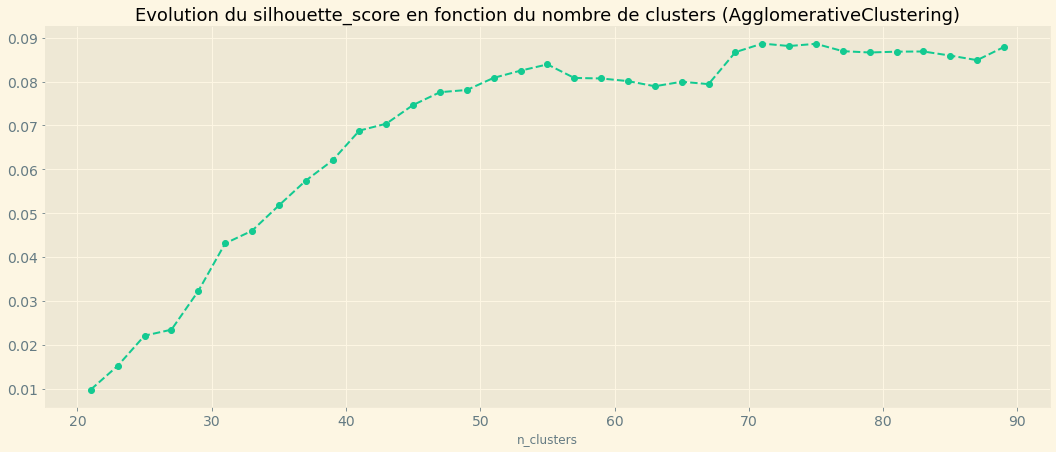

In [19]:
fig, ax = plt.subplots(figsize=(18, 7))
ax.plot(range(21, 91, 2), silhouette_scores, "--o", color=COLORS[3])
ax.set_xlabel("n_clusters")
ax.set_title("Evolution du silhouette_score en fonction du nombre de clusters (AgglomerativeClustering)")
plt.show()

In [20]:
# On entraine un modèle pour la valeur de n_clusters optimale (au coude)
ac = AgglomerativeClustering(n_clusters=51, affinity="precomputed", linkage="complete")
ac.fit(cosine_matrix)

AgglomerativeClustering(affinity='precomputed', linkage='complete',
                        n_clusters=51)

In [21]:
# taille des clusters
np.bincount(ac.labels_)

array([ 4,  5,  7,  4,  2,  4,  6,  2,  3,  2,  4,  4,  3,  2, 10,  2,  4,
        3,  4,  2,  7,  3,  3,  2,  2,  2,  2,  2,  3,  2,  6,  2,  4,  3,
        4,  2,  3,  2,  2,  2,  3,  3,  2,  3,  3,  4,  2,  1,  3,  2,  2])

In [22]:
# on peut regarder quelques clusters (de 0 à 2) en changeant le test sur sc.labels_
trimmed_ingredients[ac.labels_ == 2]

array(['amandes', 'cannelle', 'cumin', 'raisins secs', 'ras el hanout',
       'safran', "épaule d'agneau"], dtype='<U34')

<br>

### Par SpectralClustering

In [23]:
# historique des silhouette_scores pour les différents essais
silhouette_scores = []

# on pré-calcule la matrice des cosinus
cosine_matrix = cosine_similarity(trimmed_vectors.T)

# essais de clustering spectral pour plusieurs valeurs de n_clusters
for n_clusters in range(3, 53, 2):
    sc = SpectralClustering(n_clusters=n_clusters, affinity="precomputed")
    sc.fit(cosine_matrix)
    score = silhouette_score(trimmed_vectors.T, sc.labels_, metric="cosine")
    silhouette_scores.append(score)

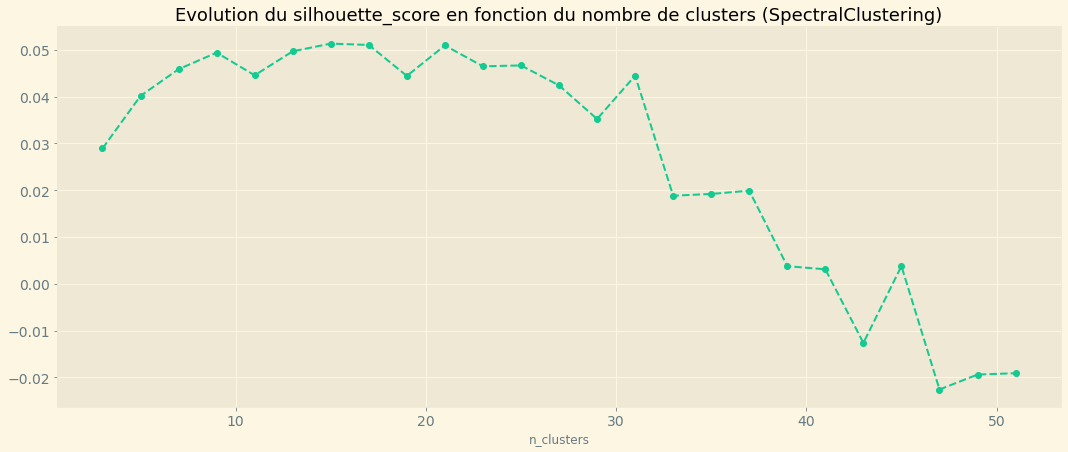

In [24]:
fig, ax = plt.subplots(figsize=(18, 7))
ax.plot(range(3, 53, 2), silhouette_scores, "--o", color=COLORS[3])
ax.set_xlabel("n_clusters")
ax.set_title("Evolution du silhouette_score en fonction du nombre de clusters (SpectralClustering)")
plt.show()

In [25]:
# On entraine un modèle pour la valeur de n_clusters optimale (21 en moyenne)
sc = SpectralClustering(n_clusters=21, affinity="precomputed")
sc.fit(cosine_matrix)

SpectralClustering(affinity='precomputed', n_clusters=21)

In [26]:
# taille des clusters
np.bincount(sc.labels_)

array([ 4, 60,  2,  4,  4,  7,  2,  5,  5,  3,  2,  4,  4,  9,  6, 18,  4,
        5,  2,  9,  4])

In [27]:
# on peut regarder quelques clusters (de 0 à 20) en changeant le test sur sc.labels_
trimmed_ingredients[sc.labels_ == 11]

array(['crème', 'margarine', 'moutarde de dijon', 'rôti de porc'],
      dtype='<U34')

<br>

### Par modèle Tok2Vec

In [28]:
# on crée un itérateur sur les ingrédients des recettes
documents = [recipe["ingredients"] for recipe in booklet.recipes]

In [29]:
# on utilise un modèle Word2Vec de gensim qui est capable de gérer nos "mots",
# même si ils contiennent plusieurs mots au sens courant (on parle de jetons ou tokens)
model = Word2Vec(documents, window=4, min_count=6, vector_size=13, sg=1)

In [30]:
# on peut tester la proximité des ingrédients par la méthode most_similar
model.wv.most_similar("vin blanc")

[('fond de veau', 0.9942062497138977),
 ('boeuf', 0.9920138120651245),
 ('béchamel', 0.9913597702980042),
 ('crème fraîche épaisse', 0.9894379377365112),
 ('crevettes', 0.9888281226158142),
 ('eau', 0.9886533617973328),
 ('saumon fumé', 0.9880793690681458),
 ('boeuf haché', 0.9880313277244568),
 ('parmesan râpé', 0.987637460231781),
 ('pois chiches', 0.9874383807182312)]

<br>

### Etude d'embeddings locaux

Représentation en dimension 2 de notre jeu de données en préservant les clusters
et affinités locales présentes en dimension supérieure (via TSNE et SpectralEmbedding)

In [31]:
from sklearn.manifold import SpectralEmbedding, TSNE

In [32]:
emb1 = SpectralEmbedding(affinity="precomputed").fit_transform(cosine_matrix)
emb2 = TSNE().fit_transform(trimmed_vectors.T)

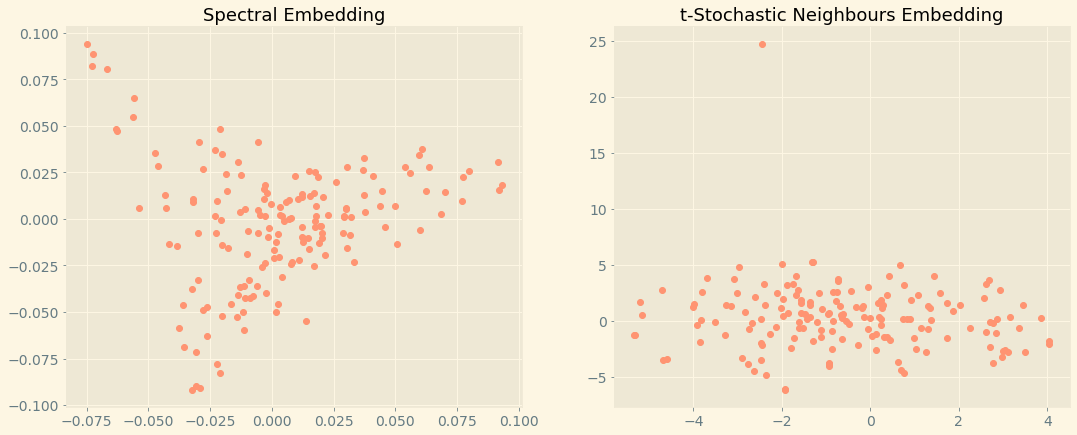

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
axes[0].scatter(emb1[:,0], emb1[:, 1], color=COLORS[0])
axes[0].set_title("Spectral Embedding")
axes[1].scatter(emb2[:,0], emb2[:, 1], color=COLORS[0])
axes[1].set_title("t-Stochastic Neighbours Embedding")
plt.show()

<br>

## Pour aller plus loin

Les méthodes de clustering présentées ici ne fonctionnent pas terriblement ...

Les embeddings en dimension 2 présentés ci-dessus confirment l'absence de clusters en haute 
dimension, de structure ou bien de hiérarchie entre les différents ingrédients.

Il semble nécessaire de récupérer d'avantage de donnée afin de réaliser une étude plus 
représentative des interactions entre les ingrédients au sein des différentes recettes
de Marmiton.

Il serait également intéressant de croiser ces recettes avec d'autres sources disponibles sur internet.

Il pourrait également être intéressant de réaliser un premier travail de groupement
des ingrédients qui se ressemblent via le traitement du language, par exemple regrouper
`huile`, `huile d'olive`, `huile d'arachide` et autres sous la même appellation.  

Le modèle Tok2Vec pourrait bien fonctionner et donne de premier résultats pertinents
mais, là encore, la faible quantité de données ne permet pas de mettre en avant des relations
entre les recettes et les ingrédients.



EDIT : Au moment de la rédaction de la conclusion, je n'avais récupéré qu'une vingtaine de
pages pour environ 600 recettes et 600 ingrédients uniques. J'ai depuis essayé de scraper l'intégralité
ou presque du site. Cela rallonge la durée de traitement considérablement mais les résultats de sortie 
sont probants, nottament le Tok2Vec qui ressort alors des résultats de hautes qualité quant à la 
similitude des ingrédients.